# Deep Learning 101
Deep learning is one of the most impactful technologies of the past few years and will continue to be of huge importance for our technological advancement. It's therefore important to have a good understanding of the basics before tackling more complex problems with existing libraries like Tensorflow or Pytorch. However, a lot of people still make wrong assumptions about what deep learning is or just see it as some kind of black magic. To help remedy this I wrote a series of blogs together with this repository. This notebook follows along with the blogs, explaining step by step what is going on.

The blogs on medium:
- Part 1 discusses the basics and the forward pass:  TBD
- Part 2 discusses backpropagation:  TBD
- Part 3 goes over several techniques to improve the learning ability of a network:  TBD

This notebook handles the contents of the third blog.

In [1]:
# To make our lives a bit easier, I'll be using numpy 
import numpy as np

# Later on we will also be creating some plots to visualize our results.
import matplotlib.pyplot as plt

## Recap from the previous blog

In [54]:
# Activations
class ReLU:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = np.maximum(0, self.inputs)
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return self.inputs > 0
    
class Sigmoid:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = 1 / (1 + np.exp(-self.inputs))
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return self.output * (1 - self.output)
    
class Tanh:
    def forward(self, inputs):
        """Forward pass of the activation function"""
        self.inputs = inputs
        self.output = np.tanh(self.inputs)
        return self.output
    
    def derivative_activation(self):
        """Backward pass of the activation function"""
        return 1 - self.output ** 2

# Layer
class Dense:
    def __init__(self, input_size, output_size):
        """Constructor of a single fully connected layer

        Args:
            input_size (int): number of inputs to this layer
            output_size (int): number of neurons in this layer, which is equivalent to the number of outputs
        """
        self.input_size = input_size
        self.output_size = output_size
        
        # Create our matrix with weights and biases for the layer
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros(output_size)
        
    def forward(self, inputs):
        """Forward pass of the layer"""
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights.T) + self.biases
        return self.output
    
    def update_gradients(self, gradients):
        """Update the gradients of the layer"""
        self.gradients = gradients
        
    def optimize(self, learning_rate):
        """Optimize the weights by taking a step in the direction of the gradients"""
        self.weights -= learning_rate * (np.dot(self.gradients.T, self.inputs) / self.input_size)
        self.biases -= learning_rate * np.mean(self.gradients, axis=0)
        
# Network
class Network:
    def __init__(self, layers, activations, learning_rate):
        """Constructor of a neural network
        
        Args:
            layers (list): list of integers, each integer corresponds to the number of neurons in a layer
            activations (list): list of activation functions, each activation function corresponds to a layer
        """
        self.layers = layers
        self.activations = activations
        self.learning_rate = learning_rate
        
    def forward(self, inputs):
        """Forward pass of the network"""
        self.inputs = inputs
        for i in range(len(self.layers)):
            self.inputs = self.activations[i].forward(self.layers[i].forward(self.inputs))
        return self.inputs
    
    def backward(self, loss):
        """Backward pass of the network"""
        self.gradients = loss * self.activations[-1].derivative_activation()   # dZ = dA * act'(Z)
        self.layers[-1].update_gradients(self.gradients)
        
        for i in range(len(self.layers) - 2, -1, -1):
            self.gradients = np.dot(self.gradients, self.layers[i+1].weights)  # dA = dZ dot W
            self.gradients = self.gradients * self.activations[i].derivative_activation() # dZ = dA * act'(Z)
            self.layers[i].update_gradients(self.gradients)             

    def optimize(self):
        """Optimize the network"""
        for layer in self.layers:
            layer.optimize(self.learning_rate)

## Minibatches
In our previous implementations we only did a gradient step after passing through the whole dataset. This makes the learning process very slow, especially in practice where the datasets can be a lot larger and the models are more complex. In practice we therefore use minibatches, which are subsets of the dataset. After passing through each minibatch we do a backward pass and update the weights, this way multiple backward passes can be done in a single epoch. Let's try this out.

In [25]:
def function_to_model(input):
    if input < -50:
        return 0
    elif input < 0:
        return (input + 50) / 50
    elif input < 50:
        return 1
    else:
        return (50 - input) / 50 + 1

x_train = np.linspace(-100, 100, 1000).reshape(-1, 1)
y_train = np.fromiter((function_to_model(x) for x in x_train), dtype=x_train.dtype).reshape(-1, 1)

train_indices = np.arange(0, len(x_train))

x_test = np.linspace(-95, 95, 200).reshape(-1, 1)
y_test = np.fromiter((function_to_model(x) for x in x_test), dtype=x_test.dtype).reshape(-1, 1)

In [26]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

0.05669600113141907


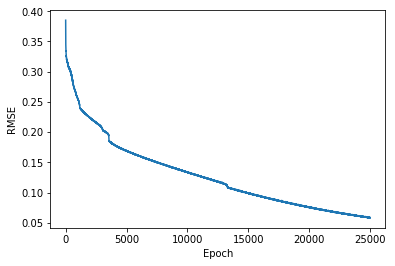

In [32]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.0001)

losses = []

for epoch in range(25000):
    # Keep track of the training batch losses
    batch_losses = []
    
    # Batches should be random    
    np.random.shuffle(train_indices)
    
    # Loop through the training data in minibatches of size 200
    for batch in range(len(x_train) // 100):
        batch_indices = train_indices[batch * 100:(batch + 1) * 100]
        x_train_batch = x_train[batch_indices]
        y_train_batch = y_train[batch_indices]
        
        y_pred_batch = network.forward(x_train_batch)
        batch_losses.append(rmse(y_pred_batch, y_train_batch))
        network.backward(y_pred_batch - y_train_batch)
        network.optimize()
    
    losses.append(np.mean(np.array(batch_losses)))

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

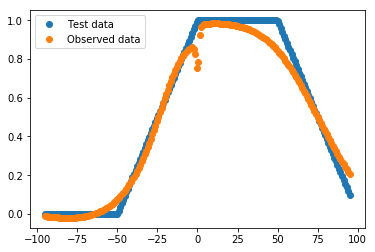

In [33]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

By doing this the learning rate could be increased with a factor 10 and we achieved the best performance yet. On top of that we can see that there is still room for further improvement if we train the algorithm for more epochs. However, let's look at another modification that we can make to improve the training process.

## Momentum
In practice we typically don't use the standard backpropagation algorithm, we use optimization algorithms that have extended upon the core backpropagation algorithm in order to make training faster and more stable.
One such extension is called momentum. Imagine the weight and bias updates as a ball rolling down a hill. The ball shouldn't start erratically moving in different directions. It builds some momentum down the slope and it will keep some of that momentum, while changing under the influence of the changes in slope. This idea can also be applied here. By keeping track of the momentum, we can reduce erratic behavior in the subsequent gradient steps.

Adding the momentum term to the layer is quite simple:


In [34]:
class Dense:
    def __init__(self, input_size, output_size):
        """Constructor of a single fully connected layer

        Args:
            input_size (int): number of inputs to this layer
            output_size (int): number of neurons in this layer, which is equivalent to the number of outputs
        """        
        self.input_size = input_size
        self.output_size = output_size
        
        # Create our matrix with weights and biases for the layer
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros(output_size)
        # Momentum terms
        self.VdW = np.zeros((output_size, input_size))
        self.Vdb = np.zeros(output_size)
        
    def forward(self, inputs):
        """Forward pass of the layer"""
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights.T) + self.biases
        return self.output
    
    def update_gradients(self, gradients):
        """Update the gradients of the layer"""
        self.gradients = gradients
        
    def optimize(self, learning_rate, beta=0.9):
        """Optimize the weights by taking a step in the direction of the gradients"""        
        # Update momentum terms
        self.VdW = beta * self.VdW + (1 - beta) * (np.dot(self.gradients.T, self.inputs) / self.input_size)
        self.Vdb = beta * self.Vdb + (1 - beta) * np.mean(self.gradients, axis=0)
        
        # Update the weights and biases with the momentum
        self.weights -= learning_rate * self.VdW
        self.biases -= learning_rate * self.Vdb
        

0.023657305880780476


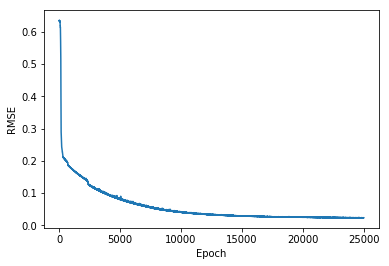

In [37]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.0005)

losses = []

for epoch in range(25000):
    # Keep track of the training batch losses
    batch_losses = []
    
    # Batches should be random    
    np.random.shuffle(train_indices)
    
    # Loop through the training data in minibatches of size 200
    for batch in range(len(x_train) // 100):
        batch_indices = train_indices[batch * 100:(batch + 1) * 100]
        x_train_batch = x_train[batch_indices]
        y_train_batch = y_train[batch_indices]
        
        y_pred_batch = network.forward(x_train_batch)
        batch_losses.append(rmse(y_pred_batch, y_train_batch))
        network.backward(y_pred_batch - y_train_batch)
        network.optimize()
    
    losses.append(np.mean(np.array(batch_losses)))

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

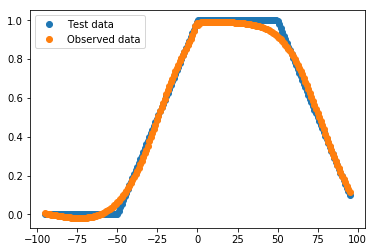

In [38]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

As you can see we can increase the learning rate even more, while keeping training stable. Resulting in an even better result. 

# RMS Prop & the Adam optimizer

A similar modification that we can make is to reduce oscillations in weights and biases. This can be done through Root Mean Squared Propagation, which is better known as RMSProp. With this technique you keep track of an average of the squared gradient for each weight and bias. Before updating the weights and biases you simply divide the gradient by the root of this average. You can see that we can combine this quite easily with the momentum modification. This combination is basically what the Adam optimizer does.

In [57]:
class Dense:
    def __init__(self, input_size, output_size):
        """Constructor of a single fully connected layer

        Args:
            input_size (int): number of inputs to this layer
            output_size (int): number of neurons in this layer, which is equivalent to the number of outputs
        """        
        self.input_size = input_size
        self.output_size = output_size
        
        # Create our matrix with weights and biases for the layer
        self.weights = np.random.randn(output_size, input_size)
        self.biases = np.zeros(output_size)
        # Momentum terms
        self.VdW = np.zeros((output_size, input_size))
        self.Vdb = np.zeros(output_size)
        # RMSProp terms
        self.SdW = np.zeros((output_size, input_size))
        self.Sdb = np.zeros(output_size)
        
    def forward(self, inputs):
        """Forward pass of the layer"""
        self.inputs = inputs
        self.output = np.dot(self.inputs, self.weights.T) + self.biases
        return self.output
    
    def update_gradients(self, gradients):
        """Update the gradients of the layer"""
        self.gradients = gradients
        
    def optimize(self, learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """Optimize the weights by taking a step in the direction of the gradients"""
        # Update terms
        dW = np.dot(self.gradients.T, self.inputs) / self.input_size
        db = np.mean(self.gradients, axis=0)
                
        # Update momentum terms
        self.VdW = beta1 * self.VdW + (1 - beta1) * dW
        self.Vdb = beta1 * self.Vdb + (1 - beta1) * db
        
        # Update the RMSProp terms
        self.SdW = beta2 * self.SdW + (1 - beta2) * np.square(dW)
        self.Sdb = beta2 * self.Sdb + (1 - beta2) * np.square(db)
        
        # Update the weights and biases with the momentum
        self.weights -= learning_rate * (self.VdW / (np.sqrt(self.SdW) + epsilon))  
        self.biases -= learning_rate * (self.Vdb / (np.sqrt(self.Sdb) + epsilon))

c:\Users\Niels\AppData\Local\Programs\Python\Python36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in exp


0.0008782760956750425


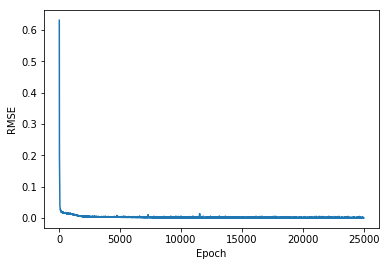

In [58]:
network = Network([Dense(1, 32), Dense(32, 32), Dense(32, 16), Dense(16, 16), Dense(16, 1)], [Sigmoid(), Sigmoid(), Sigmoid(), Sigmoid(), Tanh()], 0.0005)

losses = []

for epoch in range(25000):
    # Keep track of the training batch losses
    batch_losses = []
    
    # Batches should be random    
    np.random.shuffle(train_indices)
    
    # Loop through the training data in minibatches of size 200
    for batch in range(len(x_train) // 100):
        batch_indices = train_indices[batch * 100:(batch + 1) * 100]
        x_train_batch = x_train[batch_indices]
        y_train_batch = y_train[batch_indices]
        
        y_pred_batch = network.forward(x_train_batch)
        batch_losses.append(rmse(y_pred_batch, y_train_batch))
        network.backward(y_pred_batch - y_train_batch)
        network.optimize()
    
    losses.append(np.mean(np.array(batch_losses)))

plt.plot(losses)
plt.ylabel('RMSE')
plt.xlabel('Epoch')

# Test the network
y_hat = network.forward(x_test)
loss = rmse(y_hat, y_test)
print(loss)

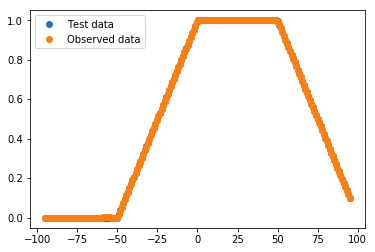

In [59]:
plt.plot(x_test, y_test, 'o', label='Test data')
plt.plot(x_test, y_hat, 'o', label='Observed data')
plt.legend()

And with that we achieved a near perfect performance in a very short amount of time. When looking at the training curve you can see we hit this kind of performance between 5000 and 10000 epochs. Compared to what we had at the end of the previous notebook this shows us just how powerful these small modifications can be. With the core backpropagation algorithm we needed 250k epochs to achieve an RMSE of about 0.06. And with that we have come to the end of these notebooks. I hope these were helpful to you and if you have any questions, feel free to contact me!